In [ ]:
!pip install transformers torch datasets transformers[torch]

from google.colab import drive
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
import json
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 24.6 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __g

ModuleNotFoundError: ignored

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/'

def json_to_df(file_name):
    with open(file_path+file_name, 'r',encoding='utf-8') as f:
        data = json.load(f)

    # json파일의 데이터를 DataFrame 형식으로 변환하고 label값 False > 0, True > 1로 변환
    df = pd.json_normalize(data, record_path = ['sentences'], meta=['id'], record_prefix='sent_')
    df = df.drop(columns = ['sent_id', 'sent_speaker', 'sent_types', 'sent_intensity_sum',
                            'sent_text', 'sent_intensity', 'sent_votes', 'sent_frame_id', 'sent_mapped_slots'])
    df.replace({False:'0', True:'1'}, inplace=True)

    # 오타 제거
    df['sent_origin_text'] = df['sent_origin_text'].str.replace('\\','')

    # id 기준으로 데이터 병합
    df = df.groupby('id').agg(list)
    df.reset_index(drop=True, inplace=True)
    df.columns = ['text', 'label']

    return df

df = json_to_df('talksets-train-1.json')
df

In [ ]:
label_len = [0 for i in range(30)]
count = 0

for i in range(len(df)):
    if len(df['label'][i]):
        idx = len(df['label'][i])
        label_len[idx - 1] += 1
        count += 1

print(count, label_len)

19689 [0, 1300, 12402, 2191, 1978, 1266, 296, 102, 82, 43, 7, 6, 2, 0, 2, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2]


<BarContainer object of 30 artists>

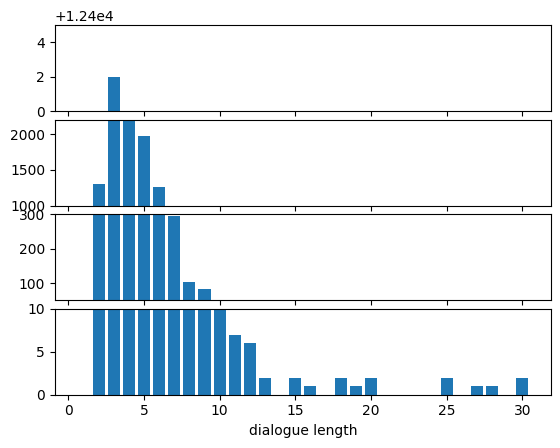

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 31)]
y = label_len

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(hspace = 0.1)
plt.xlabel('dialogue length')

ax1.set_ylim(12400, 12405)
ax2.set_ylim(1000, 2200)
ax3.set_ylim(50, 300)
ax4.set_ylim(0, 10)

ax1.bar(x, y)
ax2.bar(x, y)
ax3.bar(x, y)
ax4.bar(x, y)